In [1]:
import numpy as np
from numba import cuda
import time
import matplotlib.pyplot as plt

### Synthetic data

In [4]:
listsizes = [20,60,120,160,200]
args_list = list()
for ls in listsizes:
    x = list(np.random.randint(0,400,ls))
    y = list(np.random.randint(0,200,ls))
    m = len(x)
    n = len(y)
    z = x + y;z.sort()
    S = sum(z[m:])
    dtype = np.uint16
    args_list.append([m,n,S,z,dtype])


In [142]:
np.random.seed(1)
#A = np.asarray([np.random.beta(2.0,5.0,7) for _ in range(1)])
#B = np.asarray([np.random.beta(2.0,5.0,20) for _ in range(1)])
A = np.asarray([np.random.randint(0,5,5) for _ in range(1)])
B = np.asarray([np.random.randint(0,5,5) for _ in range(1)])


In [143]:
A

array([[3, 4, 0, 1, 3]])

In [144]:
args_list = list()
x = list(A[0])
y = list(B[0])
m = len(x)
n = len(y)
z = x + y;z.sort()
S = sum(z[m:])
dtype = np.uint16
args_list.append([m,n,S,z,dtype])

In [145]:
num_bin = np.ceil(max(z)) - np.floor(min(z)) + 1

### Mimic R's "table(factor(x, y))" function

In [146]:
def table(val, S):
    table = np.zeros(S + 1)
    for e in val:
        table[e] +=1
    return table

### Shift-function 

In [147]:
def shift(v, i): return np.pad(v[0:len(v) - i], (i,0), 'constant')

# Exact permutation test with the shift-method

In [17]:
def exact_perm_shift1(m, n, S, z, dtype):
    N = np.zeros([S + 1, m + n, m], dtype)
    for k in range(1,(m+n)+1):
        N[:,k -1,0] = table(z[0:k],S)
    
    for k in range(2,(m+n)+1):
        for j in range(2, m +1):
            N[:,k-1,j-1] = shift(N[:,k-2,j-2], z[k -1]) + N[:,k-2,j-1]
    return N[:,-1,-1]

In [155]:
def exact_perm_shift2(m, n, S, z, dtype):
    init = np.zeros([S + 1, m + n], dtype)
    for k in range(1,(m+n)+1):
        init[:,k -1] = table(z[0:k],S)

    
    N = np.zeros([S + 1, m], dtype)
    N_old = N.copy()
    for k in range(1,(m+n)+1):
        if k==1:
            N[:,0] = init[:,0]
        else:
            for j in range(1, m +1):
                if j == 1:
                    N[:,j-1] = init[:,k-1]
                else:
                    #N[:,k-1] = shift(N_old[:,k-2], z[k -1]) + N[:,k-2]
                    N[:,j-1] = shift(N_old[:,j-2], z[k -1]) + N_old[:,j-1]
        #print("-------",k,"--------------")
        #print(N)
        N_old = N.copy()
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1]

In [186]:
def exact_perm_shift2(m, n, S, z, dtype):
    N = np.zeros([S + 1, m], dtype)
    N_old = N.copy()
    
    for k in range(1,(m+n)+1):
        if k==1:
            N[z[k-1],0] += 1

        else:
            for j in range(1, m +1):
                if j == 1:
                    N[z[k-1],0] += 1
                else:
                    for i in range(S+1):        
                        if i >= z[k-1]:
                            #print(i,i - z[k -1], j-1, N_old[i - z[k -1], j-2])
                            N[i,j-1] = N_old[i - z[k -1], j-2] + N_old[i,j-1]
                        else:
                            #print(i,j-1, N_old[i,j-1])
                            N[i,j-1] = N_old[i,j-1]
                            #N[i,j-1] =0
                            
        print("----------------------")
        print(N)
        N_old = N.copy()
    


    return N_old[:,-1]

USE THIS! But have to explain why the non-zero verison works though!!!!!

In [252]:
def exact_perm_shift2S(m, n, S, z, dtype):
    N = np.zeros([S + 1, m], dtype)
    N_old = N.copy()
    
    for i in range(1,(m+n)+1):
        for j in range(1, m +1):
            for s in range(S+1):
                if i < j:
                    N[s,j-1] = 0
                elif j == 1 and z[i-1] == s:
                    N[s,j-1] = N_old[s,j-1] + 1
                elif j == 1 and z[i-1] != s:
                    N[s,j-1] = N_old[s,j-1]
                elif j > 1 and z[i-1] <= s:
                    N[s,j-1] = N_old[s - z[i -1], j-2] + N_old[s,j-1]
                elif j > 1 and z[i-1] > s:
                    N[s,j-1] = N_old[s,j-1]
         
        print("----------------------")
        print(N)
        N_old = N.copy()
        #print("----------------------")
        #print(N)
        #tmp = N_old.copy()
        #N_old = N.copy()
        #N = tmp  
        #N_old = N.copy()
        
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1]

In [255]:
def exact_perm_shiftK(m, n, S, z, dtype):
    N = np.zeros([S + 1,n+m,m], dtype)
    N_old = N.copy()
    
    for k in range(1,(m+n)+1):
        for j in range(1, m +1):
            for s in range(S+1):
                if k < j:
                    N[s, k-1, j-1] = 0
                elif j == 1 and z[k-1] == s:
                    N[s,k-1,j-1] = N[s,k-2,j-1] + 1
                elif j == 1 and z[k-1] != s:
                    N[s, k-1, j-1] = N[s, k-2, j-1]
                elif j > 1 and z[k-1] <= s:
                    N[s, k-1, j-1] = N[s - z[k -1],k-2, j-2] + N[s,k-2,j-1]
                elif j > 1 and z[k-1] > s:
                    N[s, k-1, j-1] = N[s, k-2, j-1]
         
        print("----------------------")
        print(N[:,k-1,:])
        N_old = N.copy()
        #print("----------------------")
        #print(N)
        #tmp = N_old.copy()
        #N_old = N.copy()
        #N = tmp  
        #N_old = N.copy()
        
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1,-1]

In [256]:
def exact_perm_shift2I(m, n, S, z, dtype):
    N = np.zeros([S + 1,n+m,m], dtype)
    N_old = N.copy()
    
    for j in range(1, m +1):
        for i in range(1,(m+n)+1):
            for s in range(S+1):
                if i < j:
                    N[s, i-1, j-1] = 0
                elif j == 1 and z[i-1] == s:
                    N[s,i-1,j-1] = N[s,i-2,j-1] + 1
                elif j == 1 and z[i-1] != s:
                    N[s, i-1, j-1] = N[s, i-2, j-1]
                elif j > 1 and z[i-1] <= s:
                    N[s, i-1, j-1] = N[s - z[i -1],i-2, j-2] + N[s,i-2,j-1]
                elif j > 1 and z[i-1] > s:
                    N[s, i-1, j-1] = N[s, i-2, j-1]
         
        print("----------------------")
        print(N[:,i-1,:])
        N_old = N.copy()
        #print("----------------------")
        #print(N)
        #tmp = N_old.copy()
        #N_old = N.copy()
        #N = tmp  
        #N_old = N.copy()
        
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1,-1]

In [257]:
def exact_perm_shift2S(m, n, S, z, dtype):
    N = np.zeros([S + 1,n+m,m], dtype)
    N_old = N.copy()
    
    for s in range(S+1):
        for j in range(1, m +1):
            for i in range(1,(m+n)+1):
                if i < j:
                    N[s, i-1, j-1] = 0
                elif j == 1 and z[i-1] == s:
                    N[s,i-1,j-1] = N[s,i-2,j-1] + 1
                elif j == 1 and z[i-1] != s:
                    N[s, i-1, j-1] = N[s, i-2, j-1]
                elif j > 1 and z[i-1] <= s:
                    N[s, i-1, j-1] = N[s - z[i -1],i-2, j-2] + N[s,i-2,j-1]
                elif j > 1 and z[i-1] > s:
                    N[s, i-1, j-1] = N[s, i-2, j-1]
         
        print("----------------------")
        print(N[:,i-1,:])
        N_old = N.copy()
        #print("----------------------")
        #print(N)
        #tmp = N_old.copy()
        #N_old = N.copy()
        #N = tmp  
        #N_old = N.copy()
        
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1,-1]

In [258]:
print(exact_perm_shift2(m, n, S, Z, dtype))

----------------------
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 2 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [1 2 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 2 1 0 0]
 [0 1 2 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 

In [259]:
print(exact_perm_shift2S(m, n, S, Z, dtype))

----------------------
[[4 6 4 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[ 4  6  4  1  0]
 [ 2  8 12  8  2]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
----------------------
[[ 4  6  4  1  0]
 [ 2  8 12  8  2]
 [ 0  1  4  6  4]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0

In [262]:
print(exact_perm_shift2I(m, n, S, Z, dtype))

----------------------
[[4 0 0 0 0]
 [2 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [3 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[ 4  6  0  0  0]
 [ 2  8  0  0  0]
 [ 0  1  0  0  0]
 [ 1  4  0  0  0]
 [ 3 14  0  0  0]
 [ 0  6  0  0  0]
 [ 0  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
----------------------
[[ 4  6  4  0  0]
 [ 2  8 12  0  0]
 [ 0  1  4  0  0]
 [ 1  4  6  0  0]
 [ 3 14 26  0  0]
 [ 0  6 25  0  0]
 [ 0  0  3  0  0]
 [ 0  3 12  0  0]
 [ 0  3 18  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0

In [261]:
print(exact_perm_shift2CR(m, n, S, Z, dtype))

----------------------
[[4 0 0 0 0]
 [2 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [3 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[ 4  6  0  0  0]
 [ 2  8  0  0  0]
 [ 0  1  0  0  0]
 [ 1  4  0  0  0]
 [ 3 14  0  0  0]
 [ 0  6  0  0  0]
 [ 0  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
----------------------
[[ 4  6  4  0  0]
 [ 2  8 12  0  0]
 [ 0  1  4  0  0]
 [ 1  4  6  0  0]
 [ 3 14 26  0  0]
 [ 0  6 25  0  0]
 [ 0  0  3  0  0]
 [ 0  3 12  0  0]
 [ 0  3 18  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0

In [177]:
def exact_perm_shift3(m, n, S, z, dtype):
    N = np.zeros([S + 1, m], dtype)
    N_old = N.copy()
    
    for k in range(1,(m+n)+1):
        if k==1:
            N[z[k-1],0] += 1

        else:
            for j in range(1, m +1):
                for i in range(S+1):   
                    if j == 1:
                        if i == z[k-1]:
                            N[z[k-1],0] =  N_old[z[k-1],0] + 1
                        else:
                            N[i,0] = N_old[i,0]
                            
                    else:
                        if i >= z[k-1]:
                            #print(i,i - z[k -1], j-1, N_old[i - z[k -1], j-2])
                            N[i,j-1] = N_old[i - z[k -1], j-2] + N_old[i,j-1]
                        else:
                            #print(i,j-1, N_old[i,j-1])
                            N[i,j-1] = N_old[i,j-1]
                            #N[i,j-1] =0
        
        print("----------------------")
        print(N)
        tmp = N.copy()
        N = N_old
        N_old = tmp
        #print(N)
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1]

In [178]:
def exact_perm_shift4(m, n, S, z, dtype):
    N = np.zeros([S + 1, m + n, m], dtype)
    for k in range(1,(m+n)+1):
        for s in range(S+1):
            if s == z[k]:
                N[s,k -1,0] = N[s,k - 2,0] + 1
                #N[s,k -1,0] = 1
            else:
                N[s,k -1,0] = N[s,k - 2,0] 
                
        #N[:,k -1,0] = table(z[0:k],S)
    
    print(N[:,:,0])
    #for k in range(2,(m+n)+1):
    for j in range(2, m +1):
        for k in range(2,(m+n)+1):
        #for j in range(2, m +1):
            N[:,k-1,j-1] = shift(N[:,k-2,j-2], z[k])
    print(N.shape)
    return N[:,-1,-1]
    #return np.sum(N[:,:,-1],axis=1)

In [140]:
Z

[0, 4, 0, 1, 3]

In [182]:
print(exact_perm_shift2(m, n, S, Z, dtype))

----------------------
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 2 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [1 2 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 2 1 0 0]
 [0 1 2 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 

In [183]:
print(exact_perm_shift2S(m, n, S, Z, dtype))

----------------------
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
----------------------
[[2 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 2 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 

In [151]:
def exact_perm_shift5(m, n, S, z, dtype):
    N = np.zeros([S + 1, m + n], dtype)
    N_old = N.copy()
    
    #for k in range(1,(m+n)+1):
    for j in range(0, m ):
        for k in range(0,(m+n)):
            for i in range(S+1): 
                if k <= j:
                    N[i,k] = 0
                elif j== 0:
                    #print(j)
                    if z[k] == i:
                        N[i,k] = 1
                    else:
                        N[i,k] = 0
                else:
                    if z[k] <= i:
                        N[i,k] = N_old[i - z[k],k-1]
                    else:
                        N[i,k] = N_old[i, k-1]
                        
        print(N)
        tmp = N.copy()
        N = N_old
        N_old = tmp
        print(N)
        #N = np.zeros([S + 1, m], dtype)

    return N_old[:,-1]

In [158]:
z_ = z.copy()
np.random.shuffle(z_)

In [162]:
print(exact_perm_shift5(m, n, S, z_, dtype))

[[0 0 0 0 1 0 1 0 0 1]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 0]
 [0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0

In [160]:
print(exact_perm_shift2(m, n, S, z, dtype))

[ 0  0  1  0  4 12 10 12 42 36 18 36 42 12 10 12  4  0  1]


In [86]:
z.append(0)

In [149]:
z_ = z.copy()
np.random.shuffle(z_)
Z = [0] + z_
#Z.sort()

In [127]:
z_

[3, 4, 1, 0]

In [128]:
Z

[0, 3, 4, 1, 0]

In [129]:
print(exact_perm_shift4(m, n, S, Z, dtype))

[[0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
(8, 4, 2)
[3 4 3 3 3 4 3 4]


In [69]:
exact_perm_shift3(m, n, S, z, dtype)

[[1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]]
[[1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 2]
 [0 1]
 [0 0]
 [0 1]]


array([0, 1, 0, 1, 2, 1, 0, 1], dtype=uint16)

In [161]:
exact_perm_shift2(m, n, S, z, dtype) == exact_perm_shift3(m, n, S, z, dtype)

[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[2 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[3 3 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[3 3 1 0 0]
 [1 3 3 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[3 3 1 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [24]:
def p_value_calc(args):
    a,b = args
    p=significance_of_mean(a,b, bins)[0]
    return p

def calibration_series_generator(A,B):
    num_tests = A.shape[0]
    for i in range(num_tests):
        a_sample = A[i].tolist()
        b_sample = B[i].tolist()
        yield ([a_sample,b_sample])

def calibration_test(A,B):
    with cf.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()-1) as pool:
        p_list = list(pool.map(p_value_calc, calibration_series_generator(A,B)))
    return p_list

In [25]:
np.random.randint(0,20,20)

array([11,  5, 15,  0, 16,  1, 12,  7, 13,  6, 18,  5, 18, 11, 10, 14, 18,
        4,  9, 17])

In [26]:
np.random.beta(2.0, 5.0, 20)

array([0.24841095, 0.57410846, 0.32528575, 0.07442876, 0.48306499,
       0.1853326 , 0.23212584, 0.10365042, 0.32297706, 0.33623207,
       0.2295471 , 0.3456943 , 0.18909312, 0.23143033, 0.37396674,
       0.29056453, 0.73900169, 0.21609607, 0.58114092, 0.23326222])

### A function that calculates the permutations of the sub-array on the GPU

In [265]:
from numba import cuda
@cuda.jit
def get_permutationsA_u4_v_u2_V2(X1, X2, k_, z_,S):
    n = X1.shape[0]
    m = X1.shape[1]
    L = X1.shape[2]

    i, j, z = cuda.grid(3)
    
    if j < 1 or j >= m + 1 or i > S[z] or z >= L:
        return

    if k_ == 1:
        if j == 1 and i == z_[z, k_ - 1]:
            X2[i, j - 1, z] += 1
        else:
            return
    else:
        if j == 1:
            if i == z_[z, k_ - 1]:
                X2[i, j - 1, z]= X2[i, j - 1, z] + 1
            else:
                return
            
        else:
            if i >= z_[z, k_ - 1]:
                X2[i, j - 1, z] = X1[i - int(z_[z, k_ - 1]), j - 2, z] + X1[i, j - 1, z]
            else:
                X2[i, j - 1, z] = X1[i, j - 1, z]

In [27]:
@cuda.jit("(u2[:,:,:], u2, u2)")
def get_perumations(X, k_, z_):
    n = X.shape[0]
    m = X.shape[2]
    
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    j = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    if j >= 2 and j < m + 1 and  i < n :
        if i >= int(z_):
            X[i, k_- 1, j-1] = X[i - int(z_), k_-2 ,j-2] +  X[i,k_-2,j-1]
        else:
            X[i, k_-1, j-1] = X[i,k_-2, j-1]

# Exact permutation test with a parallelized(on the GPU) version of the shift-method

In [28]:
def exact_perm_numba_shift(m, n, S, z, dtype):
    N_cuda = np.zeros([S + 1, m + n, m], dtype)
    NN, NM = N_cuda[:,0,:].shape

    for k in range(1,(m+n)+1):
        N_cuda[:,k -1,0] = table(z[0:k],S )
    
    A = N_cuda.copy()
    blockdim = (256, 3)
    griddim = (int(np.ceil((NN )/ blockdim[0])), int(np.ceil(NM/blockdim[1] + 1)))
    A = np.ascontiguousarray(A) 
    stream = cuda.stream()
    dA = cuda.to_device(A, stream)
    
    for k in range(2, (m+n)+1):
        dk = dtype(k) 
        dz = dtype(z[k - 1])
        get_perumations[griddim,blockdim, stream](dA, dk, dz)
    dA.to_host(stream)
    stream.synchronize()
    return A


In [29]:
plain_shift = list()
gpu_shift = list()
for args in args_list:
    start = time.time()
    N1 = exact_perm_shift1(*args)
    end = time.time()
    plain_shift.append(round(end - start,3))
    print("Plain")
    print(round(end - start,3))
    
    start = time.time()
    N2 = exact_perm_shift2(*args)
    end = time.time()
    plain_shift.append(round(end - start,3))
    print("Plain")
    print(round(end - start,3))
    
    #start = time.time()
    #A = exact_perm_numba_shift(*args)
    #end = time.time()
    #gpu_shift.append(round(end - start,3))
    #print("GPU")
    #print(round(end - start,3))
    
    #print(np.allclose(A[:,:,-1], N[:,:,-1]))
    print(np.allclose(N2, N1))
    
    

Plain
0.0
[[1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]]
[[1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 2]
 [0 1]
 [0 0]
 [0 1]]
Plain
0.0
True


ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

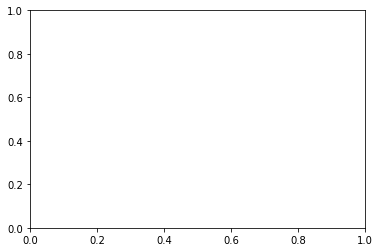

In [31]:
plt.plot(listsizes, plain_shift, 'r-', label='Plain shift-method')
plt.plot(listsizes, gpu_shift, 'g-', label='GPU shift-method')
plt.legend(loc='upper left')
plt.xlabel("Sample size")
plt.ylabel("Time(s)")
plt.savefig("figures/comparison")
plt.show()